In [1]:
import numpy as np
import math
from scipy import integrate
import matplotlib.pyplot as plt
import random
import time 
from scipy.stats import rankdata
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV
from sklearn.datasets import make_sparse_coded_signal
from scipy.stats import bernoulli

In [2]:
N = 500
M = 25000
a = np.zeros(M)
b = np.zeros(M)
m = np.zeros(M)
n = np.zeros(M)

for i in range(M-10):
    m[i] = np.random.binomial(N, 1/3)
    n[i] = np.random.binomial(N-m[i], 1/2)
    a[i] = np.random.binomial(m[i], 1/2)
    b[i] = np.random.binomial(n[i], 1/2)

for i in range(M-10,M):
    m[i] = np.random.binomial(N, 1/3)
    n[i] = np.random.binomial(N-m[i], 1/2)
    a[i] = np.random.binomial(m[i], 2/3)
    b[i] = np.random.binomial(n[i], 2/3)

stats = np.zeros(M)
order = np.zeros(M)

for i in range(M):
    order[i] = i
    if m[i] == 0:
        f = 0
    else:
        f = (2*a[i]-m[i])**2/m[i]
    if n[i] == 0:
        s = 0
    else:
        s = (2*b[i]-n[i])**2/n[i]
    if m[i] + n[i] == N:
        t = 0
    else:
        t = (2*a[i]+2*b[i]-m[i]-n[i])**2/(N-m[i]-n[i])
    
    stats[i] = f + s + t

x = np.argsort(stats)
#for i in range(10):
#    print(x[M-1-i])

stats = sorted(stats, reverse=True)
#print(sorted_stats)

In [3]:
def HaarMatrix(N):
    A = np.zeros((N,N))
    for j in range(0,N):
        A[0,j] = 1/np.sqrt(N)
    for i in range(1,N):
        for j in range(0,N):
            if N*(i-2**(np.floor(math.log2(i))))/(2**(np.floor(math.log2(i)))) <= j and j < N*(i-2**(np.floor(math.log2(i))) + 1/2)/(2**(np.floor(math.log2(i)))):
                A[i,j] = 2**(np.floor(math.log2(i))/2)/np.sqrt(N)
            elif N*(i-2**(np.floor(math.log2(i))) + 1/2)/(2**(np.floor(math.log2(i)))) <= j and j < N*(i-2**(np.floor(math.log2(i))) + 1)/(2**(np.floor(math.log2(i)))):
                A[i,j] = -2**(np.floor(math.log2(i))/2)/np.sqrt(N)
    return A

In [4]:
def BernoulliMatrix(K,N):
    phi = np.zeros((K,N))
    
    for i in range(K):
        for j in range(N):
            phi[i][j] = bernoulli.rvs(0.5, size=1)

    return (phi - 1/2) / (np.sqrt(K) / 2)

In [5]:
def OMP(A, y, N, K):
    x = np.zeros(N)
    S = np.zeros(N, dtype = np.uint8)
    r = y
    rr = np.dot(r,r)
    
    for i in range(K):
        err = rr - np.dot(A[:,S == 0].T, r) ** 2
        ndx = np.where(S == 0)[0]
        S[ndx[err.argmin()]] = 1
        
        As = A[:, S == 1]
        pinv = np.linalg.pinv(np.dot(As, As.T))
        x[S==1] = np.dot(As.T, np.dot(pinv, y))
        
        r = y - np.dot(A, x)
        rr = np.dot(r,r)
    
    return x

def OMPCL(A, y, N, K):
    x = np.zeros(N)
    S = np.zeros(N, dtype = np.uint8)
    
    for i in range(K):
        for j in range(K):
            S[j] = 1
        
        As = A[:, S == 1]
        pinv = np.linalg.pinv(np.dot(As, As.T))
        x[S==1] = np.dot(As.T, np.dot(pinv, y))
    
    return x

In [6]:
def determineS(n,d,psi,eta):
    xx = np.dot(psi.T, d)
    
    s = 0
    for i in range(n):
        if xx[i] > eta:
            s += 1
    
    if s == 0:
        s = 10
    
    return s

In [7]:
def CompressiveMechanism(g, deltag, K, epsilon, eta, phiphi, psi, AA, ss, kk):
    m = np.size(g)
    n = int(2**(np.ceil(math.log2(m))))
    
    d = np.zeros(n)
    for i in range(m):
        d[i] = g[i]
    
    y = np.dot(phiphi, d)
    pri_y = y + np.random.laplace(loc = 0.0, scale = 2*K*deltag*np.sqrt(kk)/epsilon, size=kk)
    
    pri_x = OMP(AA, pri_y, n, ss)
    
    pri_d = np.dot(psi, pri_x)
    pri_g = np.zeros(m)
    for i in range(m):
        pri_g = pri_d
    
    return pri_g

In [8]:
def CompLaplace(g, deltag, s, K, epsilon, phi, psi, A, k):
    m = np.size(g)
    n = int(2**(np.ceil(math.log2(m))))
    
    t = g[int(s)-1]
    
    x = np.zeros(n)
    for i in range(n):
        if i < m and g[i] >= t:
            x[i] = g[i]
        else:
            x[i] = 0
    
    y = np.dot(A, x)
    
    noise = (2*K/epsilon)*np.sqrt(k)*deltag*((1+(np.sqrt(n)-1)*(np.sqrt(2)+1))/np.sqrt(n))
    pri_y = y + np.random.laplace(loc = 0.0, scale = noise, size = k)
    
    pri_x = OMPCL(A, pri_y, n, s)
    
    pri_g = g + np.random.laplace(loc = 0.0, scale = 2*K*deltag/epsilon, size=m)
    
    for i in range(m):
        if g[i] >= t:
            pri_g[i] = pri_x[i]
    
    return pri_g

In [9]:
def lap_noise_normal(data, K, epsilon):
    pri_data = data + np.random.laplace(loc = 0.0, scale = 2*K*(4*N/(N+2))/epsilon, size=np.size(data))
    
    return pri_data

In [10]:
def random_num(pd):
    dist = np.cumsum(pd).tolist()
    dist[-1] = 1.0
    num = np.random.rand()
    dist.append(num)
    return sorted(dist).index(num)

def exp_mec(stats, s, m, K, epsilon):
    h = np.zeros(m)
    for i in range(m):
        h[i] = stats[i]
    S = np.zeros(K)
    k = 0
    
    w = np.zeros(m)
    p = np.zeros(m)
    
    while k < K:
        sumw = 0
        for i in range(m):
            w[i] = math.exp(epsilon * h[i] / (2*K*s))
            sumw += w[i]
        for i in range(m):
            p[i] = w[i]/sumw
            
        x = random_num(p)
        h[x] = -1000000.0
        S[k] = x
        k += 1
    
    return S

In [11]:
def calc_RE(pri_data, K, M):
    RE = 0
    pri_rank = rankdata(-pri_data)
    for i in range(K):
        for j in range(M):
            if pri_rank[j] == i + 1:
                RE += math.fabs(j-i)
                break
    RE /= K
    return RE

In [12]:
def calc_RE_exp(pri_data, K):
    RE = 0
    for i in range(K):
        RE += math.fabs(pri_data[i] - i)
    RE /= K
    return RE

In [13]:
def RankError(g, deltag, K, epsilon, s, m, phi, psi, A, k):
    RE = np.zeros(4)
    for j in range(3):
        #pri_comp_data = CompressiveMechanism(g, deltag, K, epsilon,eta, phiphi, psi, AA, ss, kk)
        #RE[0] += calc_RE(pri_comp_data, K, m)
        
        pri_complap_data = CompLaplace(g, deltag, s, K, epsilon, phi, psi, A, k)
        RE[1] += calc_RE(pri_complap_data, K, m)
        
        pri_lap_data = lap_noise_normal(g, K, epsilon)
        RE[2] += calc_RE(pri_lap_data, K, m)
        
        pri_exp_data = exp_mec(g, deltag, m, K, epsilon)
        RE[3] += calc_RE_exp(pri_exp_data, K)
    RE /= 3
        
    return RE

[[0.00000000e+00 3.33333333e+00 1.44463333e+04 2.36636667e+04]
 [0.00000000e+00 4.33333333e+00 1.87356667e+04 1.55130000e+04]
 [0.00000000e+00 3.00000000e+00 1.39923333e+04 1.54763333e+04]
 [0.00000000e+00 6.66666667e+00 3.36700000e+03 4.71900000e+03]
 [0.00000000e+00 3.66666667e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.33333333e+00 0.00000000e+00 0.00000000e+00]]
[[0.00000000e+00 6.33333333e+00 6.26766667e+03 6.92800000e+03]
 [0.00000000e+00 6.00000000e+00 8.38700000e+03 9.39666667e+03]
 [0.00000000e+00 3.66666667e+00 1.38210000e+04 6.45900000e+03]
 [0.00000000e+00 3.33333333e+00 6.66666667e-01 9.63633333e+03]
 [0.00000000e+00 5.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.66666667e+00 0.00000000e+00 0.00000000e+00]]
[[0.00000000e+00 4.33333333e+00 1.82643333e+04 1.61273333e+04]
 [0.00000000e+00 4.00000000e+00 1.62630000e+04 1.85390000e+04]
 [0.00000000e+00 3.33333333e+00 9.56133333e+03 1.01830000e+04]
 [0.00000000e+00 4.66666667e+00 8.02933333e+03 8.6590

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.00000000e+00 3.33333333e+00 1.47736667e+04 1.01140000e+04]
 [0.00000000e+00 3.33333333e+00 1.29600000e+04 1.23110000e+04]
 [0.00000000e+00 2.66666667e+00 7.93633333e+03 1.06576667e+04]
 [0.00000000e+00 2.33333333e+00 7.63933333e+03 4.01333333e+02]
 [0.00000000e+00 4.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e+00 0.00000000e+00 0.00000000e+00]]


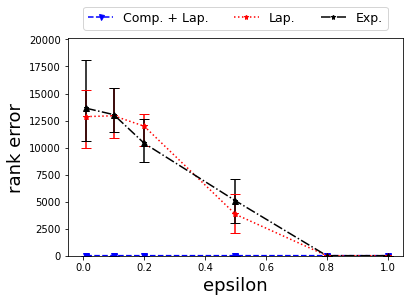

In [14]:
s = 10

n = int(2**(np.ceil(math.log2(M))))
k = int(np.floor(s*math.log(n/s)))

d = np.zeros(n)
for i in range(M):
    d[i] = stats[i]
    
psi = HaarMatrix(n)
#ss = determineS(n,d,psi,eta)
#kk = int(np.floor(ss*math.log(n/ss)))
    
#phiphi = BernoulliMatrix(kk,n)
#AA = np.dot(phiphi, psi)

phi = BernoulliMatrix(k,n)
A = np.dot(phi, psi)

K = 1

RE = np.zeros((6,4))
max_RE = np.zeros((6,4))
min_RE = np.ones((6,4)) * 10000
sum_RE = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(5):
    for i in range(6):
        RE[i] = RankError(stats, 4*N/(N+2), K, epsilon[i], s, M, phi, psi, A, k)
        
        #if RE[i][0] > max_RE[i][0]:
        #    max_RE[i][0] = RE[i][0]
        #if RE[i][0] < min_RE[i][0]:
        #    min_RE[i][0] = RE[i][0]
        if RE[i][1] > max_RE[i][1]:
            max_RE[i][1] = RE[i][1]
        if RE[i][1] < min_RE[i][1]:
            min_RE[i][1] = RE[i][1]
        if RE[i][2] > max_RE[i][2]:
            max_RE[i][2] = RE[i][2]
        if RE[i][2] < min_RE[i][2]:
            min_RE[i][2] = RE[i][2]
        if RE[i][3] > max_RE[i][3]:
            max_RE[i][3] = RE[i][3]
        if RE[i][3] < min_RE[i][3]:
            min_RE[i][3] = RE[i][3]
        sum_RE[i][0] += RE[i][0]
        sum_RE[i][1] += RE[i][1]
        sum_RE[i][2] += RE[i][2]
        sum_RE[i][3] += RE[i][3]
    print(RE)

RE = sum_RE / 5

y_err = np.zeros((2,6,4))

#y_err[0,:,0] = RE[:,0] - min_RE[:,0]
#y_err[1,:,0] = max_RE[:,0] - RE[:,0]
y_err[0,:,1] = RE[:,1] - min_RE[:,1]
y_err[1,:,1] = max_RE[:,1] - RE[:,1]
y_err[0,:,2] = RE[:,2] - min_RE[:,2]
y_err[1,:,2] = max_RE[:,2] - RE[:,2]
y_err[0,:,3] = RE[:,3] - min_RE[:,3]
y_err[1,:,3] = max_RE[:,3] - RE[:,3]
y_err /= np.sqrt(5)

fig = plt.figure()
plt.ylim(-10, 20100)
plt.xlim(-0.05, 1.05)
#plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
#plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, RE[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.5, 1.04), loc='lower center', borderaxespad=0, ncol=4, fontsize=12.5)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RE_large_M=25000_K=1.png")
fig.savefig("fig/RE_large_M=25000_K=1.eps")

[[0.00000000e+00 2.68177778e+03 8.91677778e+03 1.60688889e+04]
 [0.00000000e+00 1.97255556e+03 7.33666667e+03 1.38540000e+04]
 [0.00000000e+00 5.95555556e+02 1.21225556e+04 1.17271111e+04]
 [0.00000000e+00 3.55555556e+00 1.10606667e+04 1.47060000e+04]
 [0.00000000e+00 4.66666667e+00 1.28396667e+04 1.19348889e+04]
 [0.00000000e+00 2.77777778e+00 1.30611111e+04 8.05811111e+03]]
[[0.00000000e+00 4.00000000e+00 1.67344444e+04 1.08365556e+04]
 [0.00000000e+00 6.85666667e+02 1.46943333e+04 1.68775556e+04]
 [0.00000000e+00 2.85555556e+02 1.03050000e+04 1.31803333e+04]
 [0.00000000e+00 2.88888889e+00 1.20776667e+04 9.98588889e+03]
 [0.00000000e+00 2.44444444e+00 8.65566667e+03 1.19767778e+04]
 [0.00000000e+00 4.55555556e+00 1.01582222e+04 1.00547778e+04]]
[[0.00000000e+00 1.22922222e+03 1.31646667e+04 1.32225556e+04]
 [0.00000000e+00 4.55555556e+00 1.81521111e+04 9.65022222e+03]
 [0.00000000e+00 3.00000000e+00 1.37192222e+04 1.03514444e+04]
 [0.00000000e+00 2.66211111e+03 1.29892222e+04 1.6771

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.00000000e+00 4.22222222e+00 9.02944444e+03 1.35183333e+04]
 [0.00000000e+00 5.63533333e+03 6.23533333e+03 8.48422222e+03]
 [0.00000000e+00 4.00333333e+02 7.32411111e+03 1.25737778e+04]
 [0.00000000e+00 4.66666667e+00 1.19835556e+04 1.33474444e+04]
 [0.00000000e+00 4.77777778e+00 1.04198889e+04 1.16734444e+04]
 [0.00000000e+00 1.68555556e+02 8.59000000e+03 1.25941111e+04]]


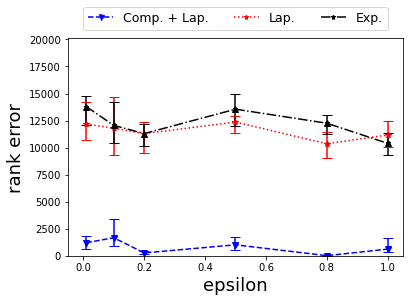

In [15]:
s = 10

K = 3

RE = np.zeros((6,4))
max_RE = np.zeros((6,4))
min_RE = np.ones((6,4)) * 10000
sum_RE = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(5):
    for i in range(6):
        RE[i] = RankError(stats, 4*N/(N+2), K, epsilon[i], s, M, phi, psi, A, k)
        
        #if RE[i][0] > max_RE[i][0]:
        #    max_RE[i][0] = RE[i][0]
        #if RE[i][0] < min_RE[i][0]:
        #    min_RE[i][0] = RE[i][0]
        if RE[i][1] > max_RE[i][1]:
            max_RE[i][1] = RE[i][1]
        if RE[i][1] < min_RE[i][1]:
            min_RE[i][1] = RE[i][1]
        if RE[i][2] > max_RE[i][2]:
            max_RE[i][2] = RE[i][2]
        if RE[i][2] < min_RE[i][2]:
            min_RE[i][2] = RE[i][2]
        if RE[i][3] > max_RE[i][3]:
            max_RE[i][3] = RE[i][3]
        if RE[i][3] < min_RE[i][3]:
            min_RE[i][3] = RE[i][3]
        sum_RE[i][0] += RE[i][0]
        sum_RE[i][1] += RE[i][1]
        sum_RE[i][2] += RE[i][2]
        sum_RE[i][3] += RE[i][3]
    print(RE)

RE = sum_RE / 5

y_err = np.zeros((2,6,4))

#y_err[0,:,0] = RE[:,0] - min_RE[:,0]
#y_err[1,:,0] = max_RE[:,0] - RE[:,0]
y_err[0,:,1] = RE[:,1] - min_RE[:,1]
y_err[1,:,1] = max_RE[:,1] - RE[:,1]
y_err[0,:,2] = RE[:,2] - min_RE[:,2]
y_err[1,:,2] = max_RE[:,2] - RE[:,2]
y_err[0,:,3] = RE[:,3] - min_RE[:,3]
y_err[1,:,3] = max_RE[:,3] - RE[:,3]
y_err /= np.sqrt(5)

fig = plt.figure()
plt.ylim(-10, 20100)
plt.xlim(-0.05, 1.05)
#plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
#plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, RE[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.5, 1.04), loc='lower center', borderaxespad=0, ncol=4, fontsize=12.5)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RE_large_M=25000_K=3.png")
fig.savefig("fig/RE_large_M=25000_K=3.eps")

[[0.00000000e+00 3.20000000e+00 1.09042667e+04 1.21767333e+04]
 [0.00000000e+00 6.47000000e+03 1.21972000e+04 1.10118667e+04]
 [0.00000000e+00 7.24153333e+03 9.67006667e+03 1.26328000e+04]
 [0.00000000e+00 5.88240000e+03 9.66773333e+03 1.12880667e+04]
 [0.00000000e+00 3.43966667e+03 1.04025333e+04 1.10202000e+04]
 [0.00000000e+00 2.10940000e+03 1.18270667e+04 8.40940000e+03]]
[[    0.          2432.06666667 14274.93333333 12603.53333333]
 [    0.          6684.06666667 14727.66666667 14566.6       ]
 [    0.           500.26666667 14165.2        14369.26666667]
 [    0.          1274.8        12419.86666667  9956.53333333]
 [    0.           565.06666667 16142.93333333 10495.4       ]
 [    0.          2510.2        13224.26666667  9027.73333333]]
[[    0.          1044.4        10131.6        12704.93333333]
 [    0.          3829.46666667 12101.93333333 16614.93333333]
 [    0.          4294.06666667 12847.46666667 12511.46666667]
 [    0.          3377.06666667 11440.         12703.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[    0.          4775.4        13532.33333333 13882.46666667]
 [    0.          3095.73333333 11202.4        13850.6       ]
 [    0.          7460.2        11518.4        11341.53333333]
 [    0.          4546.8        11696.26666667 10250.73333333]
 [    0.          4953.13333333 12043.2        13437.2       ]
 [    0.          2073.53333333 10899.6        12396.26666667]]


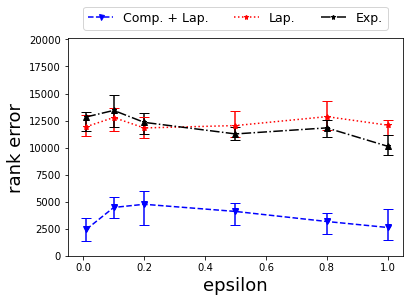

In [16]:
s = 10

K = 5

RE = np.zeros((6,4))
max_RE = np.zeros((6,4))
min_RE = np.ones((6,4)) * 10000
sum_RE = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(5):
    for i in range(6):
        RE[i] = RankError(stats, 4*N/(N+2), K, epsilon[i], s, M, phi, psi, A, k)
        
        #if RE[i][0] > max_RE[i][0]:
        #    max_RE[i][0] = RE[i][0]
        #if RE[i][0] < min_RE[i][0]:
        #    min_RE[i][0] = RE[i][0]
        if RE[i][1] > max_RE[i][1]:
            max_RE[i][1] = RE[i][1]
        if RE[i][1] < min_RE[i][1]:
            min_RE[i][1] = RE[i][1]
        if RE[i][2] > max_RE[i][2]:
            max_RE[i][2] = RE[i][2]
        if RE[i][2] < min_RE[i][2]:
            min_RE[i][2] = RE[i][2]
        if RE[i][3] > max_RE[i][3]:
            max_RE[i][3] = RE[i][3]
        if RE[i][3] < min_RE[i][3]:
            min_RE[i][3] = RE[i][3]
        sum_RE[i][0] += RE[i][0]
        sum_RE[i][1] += RE[i][1]
        sum_RE[i][2] += RE[i][2]
        sum_RE[i][3] += RE[i][3]
    print(RE)

RE = sum_RE / 5

y_err = np.zeros((2,6,4))

#y_err[0,:,0] = RE[:,0] - min_RE[:,0]
#y_err[1,:,0] = max_RE[:,0] - RE[:,0]
y_err[0,:,1] = RE[:,1] - min_RE[:,1]
y_err[1,:,1] = max_RE[:,1] - RE[:,1]
y_err[0,:,2] = RE[:,2] - min_RE[:,2]
y_err[1,:,2] = max_RE[:,2] - RE[:,2]
y_err[0,:,3] = RE[:,3] - min_RE[:,3]
y_err[1,:,3] = max_RE[:,3] - RE[:,3]
y_err /= np.sqrt(5)

fig = plt.figure()
plt.ylim(-10, 20100)
plt.xlim(-0.05, 1.05)
#plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
#plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, RE[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.5, 1.04), loc='lower center', borderaxespad=0, ncol=4, fontsize=12.5)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RE_large_M=25000_K=5.png")
fig.savefig("fig/RE_large_M=25000_K=5.eps")

[[    0.          6390.66666667 13626.26666667 13616.33333333]
 [    0.          5852.4        12003.2        14387.73333333]
 [    0.          4325.4        12356.76666667 13157.33333333]
 [    0.          7398.6        13049.         11113.8       ]
 [    0.          9283.8        12970.63333333 14145.9       ]
 [    0.          4028.76666667 14462.83333333 13008.8       ]]
[[    0.          8893.33333333 10914.86666667 12518.23333333]
 [    0.          4630.33333333 12787.         10194.93333333]
 [    0.          6836.43333333 11468.06666667 12343.9       ]
 [    0.          5104.16666667 14144.9        12224.96666667]
 [    0.          6279.9        12648.33333333 11462.03333333]
 [    0.          8444.73333333 11737.63333333 14716.06666667]]
[[    0.          9830.46666667 11146.5        11572.7       ]
 [    0.          7612.63333333 12610.8        12281.56666667]
 [    0.          5743.16666667 12279.96666667 12116.56666667]
 [    0.         10364.63333333 12832.63333333 11975.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[    0.          5877.7        13212.13333333  9957.66666667]
 [    0.          6592.1        11692.2        13579.2       ]
 [    0.          9696.73333333 11805.93333333 13877.56666667]
 [    0.          7944.73333333 11580.13333333  9673.1       ]
 [    0.          6375.7        12310.46666667 10404.8       ]
 [    0.          6769.1        11654.66666667 11437.13333333]]


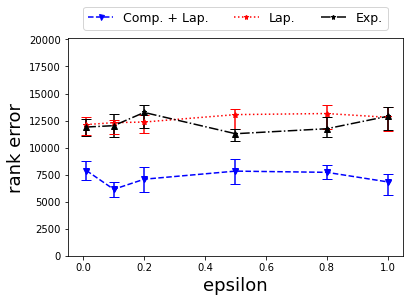

In [17]:
s = 10

K = 10

RE = np.zeros((6,4))
max_RE = np.zeros((6,4))
min_RE = np.ones((6,4)) * 10000
sum_RE = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(5):
    for i in range(6):
        RE[i] = RankError(stats, 4*N/(N+2), K, epsilon[i], s, M, phi, psi, A, k)
        
        #if RE[i][0] > max_RE[i][0]:
        #    max_RE[i][0] = RE[i][0]
        #if RE[i][0] < min_RE[i][0]:
        #    min_RE[i][0] = RE[i][0]
        if RE[i][1] > max_RE[i][1]:
            max_RE[i][1] = RE[i][1]
        if RE[i][1] < min_RE[i][1]:
            min_RE[i][1] = RE[i][1]
        if RE[i][2] > max_RE[i][2]:
            max_RE[i][2] = RE[i][2]
        if RE[i][2] < min_RE[i][2]:
            min_RE[i][2] = RE[i][2]
        if RE[i][3] > max_RE[i][3]:
            max_RE[i][3] = RE[i][3]
        if RE[i][3] < min_RE[i][3]:
            min_RE[i][3] = RE[i][3]
        sum_RE[i][0] += RE[i][0]
        sum_RE[i][1] += RE[i][1]
        sum_RE[i][2] += RE[i][2]
        sum_RE[i][3] += RE[i][3]
    print(RE)

RE = sum_RE / 5

y_err = np.zeros((2,6,4))

#y_err[0,:,0] = RE[:,0] - min_RE[:,0]
#y_err[1,:,0] = max_RE[:,0] - RE[:,0]
y_err[0,:,1] = RE[:,1] - min_RE[:,1]
y_err[1,:,1] = max_RE[:,1] - RE[:,1]
y_err[0,:,2] = RE[:,2] - min_RE[:,2]
y_err[1,:,2] = max_RE[:,2] - RE[:,2]
y_err[0,:,3] = RE[:,3] - min_RE[:,3]
y_err[1,:,3] = max_RE[:,3] - RE[:,3]
y_err /= np.sqrt(5)

fig = plt.figure()
plt.ylim(-10, 20100)
plt.xlim(-0.05, 1.05)
#plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
#plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, RE[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.5, 1.04), loc='lower center', borderaxespad=0, ncol=4, fontsize=12.5)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RE_large_M=25000_K=10.png")
fig.savefig("fig/RE_large_M=25000_K=10.eps")